## p-y for sand

# Notes

Need to run the code below again to reinstall the package

```shell
pip install -e . 
```

The code has been moved to the source folder for house keeping

In [16]:
from src.cpt import CPT
from pathlib import Path
import os
import plotly.io as pio
import numpy as np
import pandas as pd
from numpy import degrees, log10, pi, radians, tan, sin, cos
from src.p_y_sand import *
from src.p_y_clay import *
from src.pile import PipePile
import unittest
from src.p_y_unittests import *

### Import data from CPT file
#### - Data format - 

`key` is the identifier in the txt file, for locating the data, it shoudl be a unit identifier just above the data
`patter` - an regular experss to specify the pattern of the data, you can see the example below

After reading the data, need to change the column name, so that all calculation can know the location of the data

#### - Rename Columns - 
```python
cpt_data.update_data_column_name(['Reading','SCPT_DPTH','SCPT_RES','SCPT_FRES','SCPT_PWP2','slopex','slopey'])
```

- `SCPT_DPTH` - depth below seabed
- `SCPT_RES` - raw `qc` value
- `SCPT_FRES` - shaft resistance $f_s$
- `SCPT_RES` - tip resistance $q_c$

#### - Specify Unit - 

Need to update the unit, differnet contactor may output data in different unit, this is one by 

```python
cpt_data.set_data_unit(['MPa','MPa','MPa'])
```

unit is assigned in a sequence [$q_c$, $f_s$,$u_2$]

#### - init_CPT - 

This is calculate $\gamma_{soil}$ and calculate the overburnden stress $\sigma_v$ 


In [17]:
filename ='CPT4.A00'
fileloc = Path(r'G:\Name Folders\Current Staff\CC213\10 IiA funding\Unified CPT Methods\01 Data\CPT Data\18 0091 05 R002 CPT ASCII')

cpt_data = CPT()
cpt_data.read_ASCII(fileloc / filename,key='Data--',pattern= r'(.{7})(.{10})(.{11})(.{11})(.{11})(.{11})(.{11})')
cpt_data.update_data_column_name(['Reading','SCPT_DPTH','SCPT_RES','SCPT_FRES','SCPT_PWP2','slopex','slopey'])
cpt_data.set_data_unit(['MPa','MPa','MPa'])
cpt_data.init_CPT()

23-10-20 17:50:53 -c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\src\cpt.py:327 DEBUG - Data unit is set to ['MPa', 'MPa', 'MPa']


c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\src\cpt.py:591: RuntimeWarning:

invalid value encountered in log10

23-10-20 17:50:55 -c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\src\cpt.py:156 DEBUG - qt calculated using net area ratio of 0.85


### Input external parameters

In [31]:
Diameter = 2.0
Loading = 'Monotonic'
nkt = 12
N1 = 12
N2 = 3.22
interval = 1 #depth interval for sampling the raw CPT data
y_interval = 15 #identify the y[i] of p-y curve for sand
Isotropy = 'true'
I_p = 35

### Resample cpt_data

In [19]:
resampled_cpt_data = interpolate_cpt_data(cpt_data.df, interval)

In [20]:
resampled_cpt_data['SCPT_DPTH']

0      0
1      1
2      2
3      3
4      4
      ..
70    70
71    71
72    72
73    73
74    74
Name: SCPT_DPTH, Length: 75, dtype: int32

### Determine soil type based on Ic
Ic<2.6 for sand, >2.6 for clay

In [21]:
resampled_cpt_data ['soil_type'] = resampled_cpt_data.apply(lambda row:determine_soil_type(ic = row['Ic']), axis = 1)

### Calculate p-y parameters for sand

In [22]:
resampled_cpt_data ['phi_e'] = resampled_cpt_data.apply(lambda row:calc_phi_e(qt = row['qt'], sigma_v = row['sigma_v'], sigma_v_e = row['sigma_v_e']) if row['soil_type'] == 'sand' else None, axis = 1)
resampled_cpt_data ['C1'] = resampled_cpt_data.apply(lambda row:calc_C1(phi_e = row['phi_e']) if row['soil_type'] == 'sand' else None, axis = 1)
resampled_cpt_data ['C2'] = resampled_cpt_data.apply(lambda row:calc_C2(phi_e = row['phi_e']) if row['soil_type'] == 'sand' else None, axis = 1)
resampled_cpt_data ['C3'] = resampled_cpt_data.apply(lambda row:calc_C3(phi_e = row['phi_e']) if row['soil_type'] == 'sand' else None, axis = 1)
resampled_cpt_data ['k'] = resampled_cpt_data.apply(lambda row:calc_k(phi_e = row['phi_e']) if row['soil_type'] == 'sand' else None, axis = 1)
resampled_cpt_data ['pr'] = resampled_cpt_data.apply(lambda row:calc_pr(D = Diameter, gamma = row['gamma'], z = row['SCPT_DPTH'], C1 = row['C1'], C2 = row['C2'], C3 = row['C3']) if row['soil_type'] == 'sand' else None, axis = 1)
resampled_cpt_data ['A'] = resampled_cpt_data.apply(lambda row:calc_A(D = Diameter, z = row['SCPT_DPTH'], loading = Loading) if row['soil_type'] == 'sand' else None, axis = 1)

### Calculate undrained shear strength (su) for clay

In [23]:
resampled_cpt_data ['su'] = resampled_cpt_data.apply(lambda row:calc_su(qt = row['qt'], sigma_v = row['sigma_v'], nkt = nkt) if row['soil_type'] == 'clay' else None, axis = 1)

### Identify initial undrained shear strength (su0) for each clay layer

In [24]:
identify_soil_layers(resampled_cpt_data)

### Calculate p-y parameters for clay

In [25]:
resampled_cpt_data ['su1'] = resampled_cpt_data.apply(lambda row:calc_su1(su = row['su'], su0 = row['su0'], z= row['SCPT_DPTH']) if row['soil_type'] == 'clay' else None, axis = 1)
resampled_cpt_data ['alpha'] = resampled_cpt_data.apply(lambda row:calc_alpha(su = row['su'], sigma_v_e = row['sigma_v_e']) if row['soil_type'] == 'clay' else None, axis = 1)
resampled_cpt_data ['N_pd'] = resampled_cpt_data.apply(lambda row:calc_N_pd(alpha = row['alpha']) if row['soil_type'] == 'clay' else None, axis = 1)
resampled_cpt_data ['d'] = resampled_cpt_data.apply(lambda row:calc_d(su0 = row['su0'], su1 = row['su1'], D = Diameter) if row['soil_type'] == 'clay' else None, axis = 1)
resampled_cpt_data ['N_p0'] = resampled_cpt_data.apply(lambda row:calc_N_p0(N_1 = N1, N_2 = N2, alpha = row['alpha'], d = row['d'], D = Diameter, N_pd = row['N_pd'], z = row['SCPT_DPTH']) if row['soil_type'] == 'clay' else None, axis = 1)
resampled_cpt_data ['N_P'] = resampled_cpt_data.apply(lambda row:calc_N_P(N_pd = row['N_pd'], N_p0 = row['N_p0'], gamma = row['gamma'], z = row['SCPT_DPTH'], su = row['su'], isotropy = Isotropy) if row['soil_type'] == 'clay' else None, axis = 1)
resampled_cpt_data ['pu'] = resampled_cpt_data.apply(lambda row:calc_pu(su = row['su'], D = Diameter, N_P = row['N_P']) if row['soil_type'] == 'clay' else None, axis = 1)
resampled_cpt_data ['OCR'] = resampled_cpt_data.apply(lambda row:calc_OCR(Qt1 = row['Qt1']) if row['soil_type'] == 'clay' else None, axis = 1)

### Generate p-y curves

In [26]:
for i in range(12):
    resampled_cpt_data[f'y{i}'] = resampled_cpt_data.apply(lambda row:calc_y_mo(I_p = I_p, OCR = row['OCR'], D= Diameter, id_p = i) if row['soil_type'] == 'clay' else calc_y(y_interval = y_interval, i = i), axis = 1)
    resampled_cpt_data[f'p{i}'] = resampled_cpt_data.apply(lambda row:calc_p_mo(pu = row['pu'], id_p = i) if row['soil_type'] == 'clay' else calc_p(y = row[f'y{i}'], A = row['A'], pr = row['pr'], z = row['SCPT_DPTH'], k = row['k']), axis = 1)

### Export results and plot figures

cpt_data_resampled.xlsx has been exported successfully.


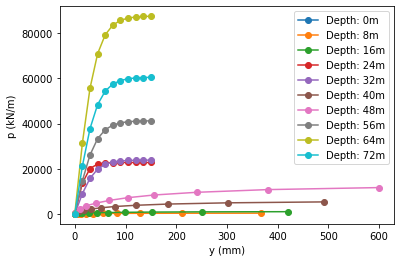

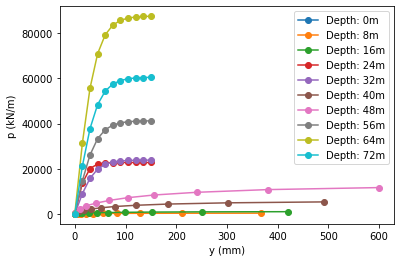

In [32]:
export_p_y_sand(resampled_cpt_data, "cpt_data_resampled.xlsx")
plot_p_y_curve(resampled_cpt_data, 8)

### Unittests

In [28]:
# Create a TestSuite object
suite = unittest.TestSuite()

# Add the test_p_y_sand_monotonic method to the TestSuite
suite.addTest(TestUnifiedCPT('test_p_y_sand_monotonic'))
suite.addTest(TestUnifiedCPT('test_p_y_sand_cyclic'))
suite.addTest(TestUnifiedCPT('test_p_y_clay_monotonic'))

# Create a TestRunner object
runner = unittest.TextTestRunner()

# Run the TestSuite using the TestRunner
runner.run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [29]:
def identify_soil_layers(cpt_data):
    # Initialize variables
    prev_soil_type = None
    layer_counts = []
    layer_thicknesses = []
    layer_types = []
    layer_strengths_0 = []

    # Iterate over rows in the DataFrame
    for i, row in cpt_data.iterrows():
        # Check if this row has a different soil type than the previous row
        if row['soil type'] != prev_soil_type:
            # If this is not the first layer, record the count, thickness, soil type, and initial strength of the previous layer
            if prev_soil_type is not None:
                layer_counts.append(layer_count)
                layer_thickness = cpt_data.loc[i-1, 'depth'] - cpt_data.loc[i-layer_count, 'depth']
                layer_thicknesses.append(layer_thickness)
                layer_types.append(prev_soil_type)
                layer_strengths_0.append(cpt_data.loc[i-layer_count, 'strength'])
            # Reset the layer count and update the previous soil type
            layer_count = 1
            prev_soil_type = row['soil type']
        else:
            # Increment the layer count if the soil type is the same as the previous row
            layer_count += 1

    # Record the count, thickness, soil type, and initial strength of the last layer
    layer_counts.append(layer_count)
    layer_thickness = cpt_data['depth'].max() - cpt_data.loc[len(cpt_data)-layer_count, 'depth']
    layer_thicknesses.append(layer_thickness)
    layer_types.append(prev_soil_type)
    layer_strengths_0.append(cpt_data.loc[len(cpt_data)-layer_count, 'strength'])

    # Add the 'strength_0' column to the DataFrame
    cpt_data['strength_0'] = pd.Series([val for val, count in zip(layer_strengths_0, layer_counts) for i in range(count)], index=cpt_data.index)

    # Append the 'strength_0' value to each row of the DataFrame
    for i, row in cpt_data.iterrows():
        row['strength_0'] = layer_strengths_0[layer_types.index(row['soil type'])]

    # Print the results
    print(cpt_data)

# Initialize sample DataFrame
cpt_data = pd.DataFrame({
    'depth': [0.0, 1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.0, 12.0, 15.0],
    'soil type': ['clay', 'clay', 'sand', 'sand', 'sand', 'clay', 'clay', 'sand', 'clay', 'sand'],
    'strength': [10, 12, 20, 22, 24, 15, 18, 19, 20, 20]
})

# Call the identify_soil_layers function
identify_soil_layers(cpt_data)

   depth soil type  strength  strength_0
0    0.0      clay        10          10
1    1.5      clay        12          10
2    3.0      sand        20          20
3    4.5      sand        22          20
4    6.0      sand        24          20
5    7.5      clay        15          15
6    9.0      clay        18          15
7   10.0      sand        19          19
8   12.0      clay        20          20
9   15.0      sand        20          20
